In [1]:
import os
import torch
import cv2
import cPickle
import numpy as np
import errno

from faster_rcnn import network
from faster_rcnn.faster_rcnn_x import FasterRCNN, FasterRCNN_x
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms

from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir
from faster_rcnn.datasets.voc_eval import voc_eval
import pickle

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline
from itertools import cycle
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
lw = 2

<bound method oneraroom.default_roidb of <faster_rcnn.datasets.oneraroom.oneraroom object at 0x7faa63acda50>>
Remove empty annotations:  Done. [ 3888 removed]


In [68]:
pytorchpath = '/home/jguerry/workspace/jg_dl/jg_pyt/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_oneraroom.yml'
# load config
cfg_from_file(cfg_file)

imdb_test_name_0 = 'oneraroom_easy_rgb'
imdb_0 = get_imdb(imdb_test_name_0)

annopath = os.path.join(imdb_0._data_path,'annotations', '{:s}.xml')
imagesetfile = os.path.join(imdb_0._data_path,'sets',imdb_0._image_set + '.txt')

# ONERAROOM
basicPath = '/home/jguerry/workspace/jg_dl/jg_pyt/output/faster_rcnn_oneraroom_exp/'
myList={}

#Y
myList['y_blackout']={'path':basicPath+'inout_y_on_oneraroom_easy_rgbd_100000_blackout/detectionsinout_y_on_oneraroom_easy_rgbd_100000_blackout.pkl',
                           'name':'Fusion Y RGB-D [blackout]', 'results':{}}

myList['inout_y_on_oneraroom_easy_rgbd_100000']={'path':basicPath+'inout_y_on_oneraroom_easy_rgbd_100000/detectionsinout_y_on_oneraroom_easy_rgbd_100000.pkl',
                           'name':'Fusion Y RGB-D', 'results':{}}


# X
myList['x_blackout']={'path':basicPath+'inout_x_on_oneraroom_easy_rgbd_10000_blackout/detectionsinout_x_on_oneraroom_easy_rgbd_10000_blackout.pkl',
                           'name':'Fusion X RGB-D [blackout]', 'results':{}}

myList['inout_x_on_oneraroom_easy_rgbd_10000']={'path':basicPath+'inout_x_on_oneraroom_easy_rgbd_10000/detectionsinout_x_on_oneraroom_easy_rgbd_10000.pkl',
                           'name':'Fusion X RGB-D', 'results':{}}

# CLASSIC
myList['oneraroom_easy_rgb']={'path':basicPath+'oneraroom_easy_rgb/detections_inout_jg_train_Images_on_oneraroom_easy_rgb.pkl',
                           'name':'RGB', 'results':{}}
myList['oneraroom_easy_depth_8bits']={'path':basicPath+'oneraroom_easy_depth_8bits/detections_inout_jg_train_Depth_on_oneraroom_easy_depth_8bits.pkl',
                           'name':'D', 'results':{}}

<bound method oneraroom.default_roidb of <faster_rcnn.datasets.oneraroom.oneraroom object at 0x7faa5cabe690>>
Remove empty annotations:  Done. [ 3888 removed]


In [57]:
pytorchpath = '/home/jguerry/workspace/jg_dl/jg_pyt/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_inout.yml'
# load config
cfg_from_file(cfg_file)

imdb_test_name_0 = 'inout_test_Images'
imdb_0 = get_imdb(imdb_test_name_0)


annopath = os.path.join(imdb_0._data_path,'Annotations_pv', '{:s}.xml')
imagesetfile = os.path.join(imdb_0._data_path,'ImageSets',imdb_0._image_set + '.txt')


# INOUT train test
basicPath = '/home/jguerry/workspace/jg_dl/jg_pyt/output/faster_rcnn_inout_exp/'
myList={}


myList['inout_test_Images_inout_test_Depth']={'path':basicPath+'inout_test_Images_inout_test_Depth/detections_inout_x_10000.pkl',
                           'name':'Fusion RGB-D', 'results':{}}
myList['inout_test_Images']={'path':basicPath+'inout_test_Images/detections_inout_Images_10000.pkl',
                           'name':'RGB', 'results':{}}
myList['inout_test_Depth']={'path':basicPath+'inout_test_Depth/detections_inout_Depth_10000.pkl',
                           'name':'D', 'results':{}}

<bound method inout.default_roidb of <faster_rcnn.datasets.inout.inout object at 0x7faa5ca83f10>>
Remove empty annotations:  Done. [ 38 removed]


In [69]:
cachedir = os.path.join(imdb_0._devkit_path, 'faster_rcnn', 'annotations_cache')
use_07_metric = False
if not os.path.isdir(basicPath):
    os.mkdir(basicPath)
cls='person'
for key in myList:
    print key
    all_boxes = pickle.load( open( myList[key]['path'], "rb" ) )
    for cls_ind, cls in enumerate(imdb_0.classes):
        if cls == '__background__':
            continue
        print 'Writing {} VOC results file'.format(cls)
        filename = imdb_0._get_voc_results_file_template().format(cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(imdb_0.image_index):
                dets = all_boxes[cls_ind][im_ind]
                if dets == []:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in xrange(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                        format(index, dets[k, -1],              # filename(stem), score
                               dets[k, 0] + 1, dets[k, 1] + 1,  # x1, y1, x2, y2
                               dets[k, 2] + 1, dets[k, 3] + 1))
    
    
    for i, cls in enumerate(imdb_0._classes):
        if cls == '__background__':
            continue
        filename = imdb_0._get_voc_results_file_template().format(cls)
        rec, prec, ap = voc_eval(filename, annopath, imagesetfile, cls, cachedir,
                                 ovthresh=0.5, use_07_metric = use_07_metric)
        myList[key]['results'][cls]={'rec':rec,'prec':prec,'ap':ap}




oneraroom_easy_rgb
Writing person VOC results file
Reading annotation for 1/5546


/data/soft/anaconda2/envs/pyt3/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Reading annotation for 201/5546
Reading annotation for 401/5546
Reading annotation for 601/5546
Reading annotation for 801/5546
Reading annotation for 1001/5546
Reading annotation for 1201/5546
Reading annotation for 1401/5546
Reading annotation for 1601/5546
Reading annotation for 1801/5546
Reading annotation for 2001/5546
Reading annotation for 2201/5546
Reading annotation for 2401/5546
Reading annotation for 2601/5546
Reading annotation for 2801/5546
Reading annotation for 3001/5546
Reading annotation for 3201/5546
Reading annotation for 3401/5546
Reading annotation for 3601/5546
Reading annotation for 3801/5546
Reading annotation for 4001/5546
Reading annotation for 4201/5546
Reading annotation for 4401/5546
Reading annotation for 4601/5546
Reading annotation for 4801/5546
Reading annotation for 5001/5546
Reading annotation for 5201/5546
Reading annotation for 5401/5546
inout_y_on_oneraroom_easy_rgbd_100000
Writing person VOC results file
Reading annotation for 1/5546
Reading annot

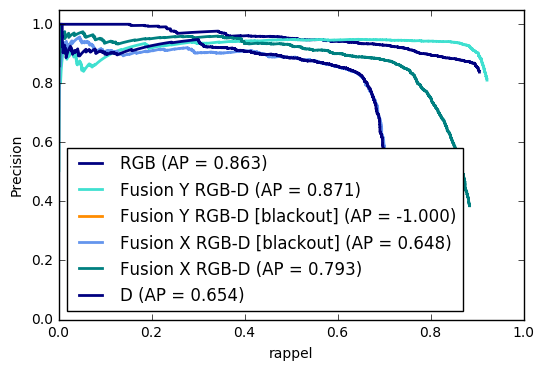

In [75]:
# Plot Precision-Recall curve for each class
plt.clf()
i=0
for key in myList:
#     print key, np.mean(myList[key]['results']['person']['rec'])
    plt.plot(myList[key]['results']['person']['rec'], myList[key]['results']['person']['prec'], color=colors[i%len(colors)], lw=lw,
             label=myList[key]['name']+' (AP = {:.3f})'.format(myList[key]['results']['person']['ap']))
    i+=1
#     +'(AP = {1:0.2f})'.format(myList[key]['results']['person']['ap'])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('rappel')
plt.ylabel('Precision')
# plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower left")
plt.show()

In [79]:
myList['y_blackout']
all_boxes = pickle.load( open( myList['y_blackout']['path'], "rb" ) )

In [80]:
all_boxes

[[[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []